# Sensitivity Analysis
This notebook analyzes sensitivity datasets to explore correlations between rankability and sensitivity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy import stats
from sklearn.linear_model import LinearRegression

In [2]:
DATA_CSV_NAME = "sensitivity_dataset_noise_sweep.csv"

In [3]:
data = pd.read_csv(DATA_CSV_NAME)
len(data)

690

In [4]:
list(data.columns)

['kendall_w',
 'p_lowerbound',
 'max_L2_dist',
 'mean_L2_dist',
 'min_tau',
 'mean_tau',
 'k',
 'degree_of_linearity',
 'model',
 'D',
 'Source',
 'n_items',
 'P',
 'P_repeats',
 'LOPRankingAlgorithm_DOL',
 'mean_tau_sensitivity(LOPRankingAlgorithm,SwapNoise(0.05))',
 'std_tau_sensitivity(LOPRankingAlgorithm,SwapNoise(0.05))',
 'mean_rho_sensitivity(LOPRankingAlgorithm,SwapNoise(0.05))',
 'std_rho_sensitivity(LOPRankingAlgorithm,SwapNoise(0.05))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,SwapNoise(0.1))',
 'std_tau_sensitivity(LOPRankingAlgorithm,SwapNoise(0.1))',
 'mean_rho_sensitivity(LOPRankingAlgorithm,SwapNoise(0.1))',
 'std_rho_sensitivity(LOPRankingAlgorithm,SwapNoise(0.1))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,SwapNoise(0.2))',
 'std_tau_sensitivity(LOPRankingAlgorithm,SwapNoise(0.2))',
 'mean_rho_sensitivity(LOPRankingAlgorithm,SwapNoise(0.2))',
 'std_rho_sensitivity(LOPRankingAlgorithm,SwapNoise(0.2))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,BootstrapResamplingNo

In [5]:
sensitivities = [col for col in data.columns if "mean_tau_sensitivity" in col]
data["overall_mean_sensitivity"] = data[sensitivities].mean(axis=1)
sensitivities

['mean_tau_sensitivity(LOPRankingAlgorithm,SwapNoise(0.05))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,SwapNoise(0.1))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,SwapNoise(0.2))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,BootstrapResamplingNoise(0.1,False))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,BootstrapResamplingNoise(0.1,True))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,BootstrapResamplingNoise(0.2,False))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,BootstrapResamplingNoise(0.2,True))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,NormalAdditiveNoise(0.1,0.9))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,NormalAdditiveNoise(1.0,0.5))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,NormalAdditiveNoise(1.0,0.2))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,NormalAdditiveNoise(1.0,1.0))',
 'mean_tau_sensitivity(MasseyRankingAlgorithm,SwapNoise(0.05))',
 'mean_tau_sensitivity(MasseyRankingAlgorithm,SwapNoise(0.1))',
 'mean_tau_sensitivity(MasseyRankingAlgorithm,SwapNoise(0.2))

In [6]:
swap_sensitivities = [col for col in sensitivities if "SwapNoise" in col]
data["swap_mean_sensitivity"] = data[swap_sensitivities].mean(axis=1)
swap_sensitivities

['mean_tau_sensitivity(LOPRankingAlgorithm,SwapNoise(0.05))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,SwapNoise(0.1))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,SwapNoise(0.2))',
 'mean_tau_sensitivity(MasseyRankingAlgorithm,SwapNoise(0.05))',
 'mean_tau_sensitivity(MasseyRankingAlgorithm,SwapNoise(0.1))',
 'mean_tau_sensitivity(MasseyRankingAlgorithm,SwapNoise(0.2))',
 'mean_tau_sensitivity(ColleyRankingAlgorithm,SwapNoise(0.05))',
 'mean_tau_sensitivity(ColleyRankingAlgorithm,SwapNoise(0.1))',
 'mean_tau_sensitivity(ColleyRankingAlgorithm,SwapNoise(0.2))']

In [7]:
bootstrap_sensitivities = [col for col in sensitivities if "BootstrapResamplingNoise" in col]
data["bootstrap_mean_sensitivity"] = data[bootstrap_sensitivities].mean(axis=1)
bootstrap_sensitivities

['mean_tau_sensitivity(LOPRankingAlgorithm,BootstrapResamplingNoise(0.1,False))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,BootstrapResamplingNoise(0.1,True))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,BootstrapResamplingNoise(0.2,False))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,BootstrapResamplingNoise(0.2,True))',
 'mean_tau_sensitivity(MasseyRankingAlgorithm,BootstrapResamplingNoise(0.1,False))',
 'mean_tau_sensitivity(MasseyRankingAlgorithm,BootstrapResamplingNoise(0.1,True))',
 'mean_tau_sensitivity(MasseyRankingAlgorithm,BootstrapResamplingNoise(0.2,False))',
 'mean_tau_sensitivity(MasseyRankingAlgorithm,BootstrapResamplingNoise(0.2,True))',
 'mean_tau_sensitivity(ColleyRankingAlgorithm,BootstrapResamplingNoise(0.1,False))',
 'mean_tau_sensitivity(ColleyRankingAlgorithm,BootstrapResamplingNoise(0.1,True))',
 'mean_tau_sensitivity(ColleyRankingAlgorithm,BootstrapResamplingNoise(0.2,False))',
 'mean_tau_sensitivity(ColleyRankingAlgorithm,BootstrapResamplingNoise(0.2,True))'

In [8]:
normal_additive_sensitivities = [col for col in sensitivities if "NormalAdditiveNoise" in col]
data["normal_additive_mean_sensitivity"] = data[normal_additive_sensitivities].mean(axis=1)
normal_additive_sensitivities

['mean_tau_sensitivity(LOPRankingAlgorithm,NormalAdditiveNoise(0.1,0.9))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,NormalAdditiveNoise(1.0,0.5))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,NormalAdditiveNoise(1.0,0.2))',
 'mean_tau_sensitivity(LOPRankingAlgorithm,NormalAdditiveNoise(1.0,1.0))',
 'mean_tau_sensitivity(MasseyRankingAlgorithm,NormalAdditiveNoise(0.1,0.9))',
 'mean_tau_sensitivity(MasseyRankingAlgorithm,NormalAdditiveNoise(1.0,0.5))',
 'mean_tau_sensitivity(MasseyRankingAlgorithm,NormalAdditiveNoise(1.0,0.2))',
 'mean_tau_sensitivity(MasseyRankingAlgorithm,NormalAdditiveNoise(1.0,1.0))',
 'mean_tau_sensitivity(ColleyRankingAlgorithm,NormalAdditiveNoise(0.1,0.9))',
 'mean_tau_sensitivity(ColleyRankingAlgorithm,NormalAdditiveNoise(1.0,0.5))',
 'mean_tau_sensitivity(ColleyRankingAlgorithm,NormalAdditiveNoise(1.0,0.2))',
 'mean_tau_sensitivity(ColleyRankingAlgorithm,NormalAdditiveNoise(1.0,1.0))']

In [9]:
true_max_L2 = data["n_items"].apply(lambda x: np.sqrt((x/3.0)*(x**2-1)))
data["max_L2_dist"] = data["max_L2_dist"] / true_max_L2
data["mean_L2_dist"] = data["mean_L2_dist"] / true_max_L2

In [10]:
def read_P(string):
    return json.loads(string.replace("(", "[").replace(")", "]"))

def read_D(string):
    return np.array(json.loads(string))

def compute_from_D(string, func=np.sum):
    return func(read_D(string))

In [11]:
# TODO (jwaschur): create train/test split for meaningful R_squared

def run_linear_model(X, y, verbose=False, skip_insignificant=False, alpha=0.05):
    if verbose:
        print("##############################")
        print("Linear model:")
        print("Predicting {} from {}".format(y.name, list(X.columns)))
    
    lm = LinearRegression()
    model = lm.fit(X,y)
    
    predictions = lm.predict(X)
    residuals = y - predictions
    R_squared = lm.score(X,y)
    coefficients = lm.coef_
    intercept = lm.intercept_
    
    # Get p-values for each of the parameters
    # Code found at https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
    params = np.append(intercept,coefficients)
    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)-1))) for i in ts_b]
    
    # Plot the model with predictions if only one predictor
    if len(X.columns) == 1:
        if skip_insignificant and p_values[1] > alpha:
            if verbose:
                print("Skipped -- Result is insignificant (alpha = {})".format(alpha))
                print("##############################\n")
            return
        col = X.columns[0]
        plt.scatter(X[col], y, alpha=0.1, color="b")
        plt.plot(X[col], predictions, color="r", label="y = {:.3E}*x + {:.3E}".format(coefficients[0], intercept))
        plt.xlabel(col)
        plt.ylabel(y.name)
        plt.legend()
        plt.title("Linear Model (R^2 = {:.3f}, p = {:.2E})".format(R_squared, p_values[1]))
        plt.show()
        plt.clf()
    else:
        print("\nR^2 = {:.3f}\n".format(R_squared))
        print("{:15}  {:8} (p-value)".format("Predictor", "Coeff"))
        print("---------------------------------------")
        print("{:15}: {:8.4f} (p = {:.2E})".format("Intercept", intercept, p_values[0]))
        for idx, col in enumerate(X.columns):
            print("{:15}: {:8.4f} (p = {:.2E})".format(col, coefficients[idx], p_values[idx+1]))
    
    if verbose:
        # Plot the histogram of residuals
        plt.hist(residuals, bins=30, density=True)
        plt.xlabel("Residual")
        plt.ylabel("Density")
        plt.title("Residual Density Histogram")
        plt.show()

        print("##############################\n")

In [12]:
rankability_measures = ["kendall_w", "p_lowerbound", "max_L2_dist", "mean_L2_dist", "min_tau", "mean_tau", "k", "degree_of_linearity"]
grouped_sensitivities = ["overall_mean_sensitivity","swap_mean_sensitivity","bootstrap_mean_sensitivity", "normal_additive_mean_sensitivity"]

##############################
Linear model:
Predicting overall_mean_sensitivity from ['swap_mean_sensitivity']


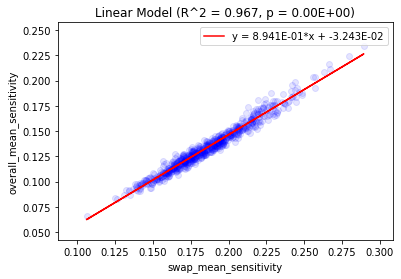

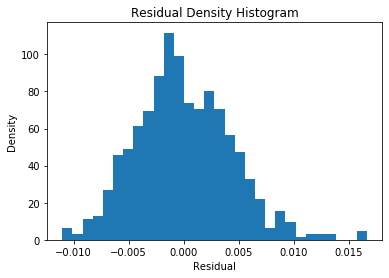

##############################

##############################
Linear model:
Predicting overall_mean_sensitivity from ['bootstrap_mean_sensitivity']


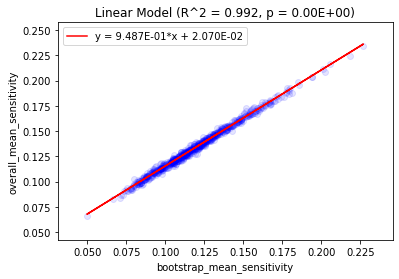

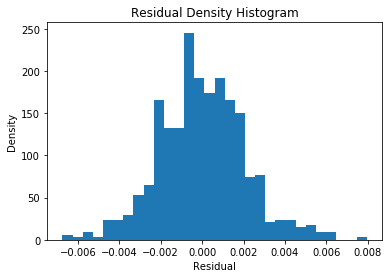

##############################

##############################
Linear model:
Predicting overall_mean_sensitivity from ['normal_additive_mean_sensitivity']


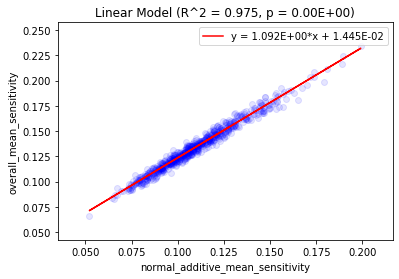

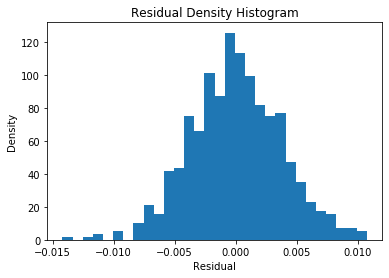

##############################

##############################
Linear model:
Predicting swap_mean_sensitivity from ['bootstrap_mean_sensitivity']


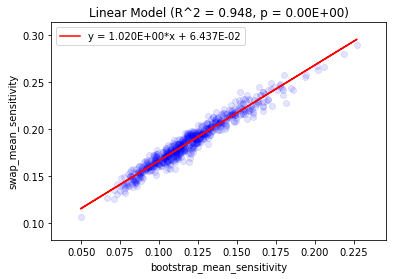

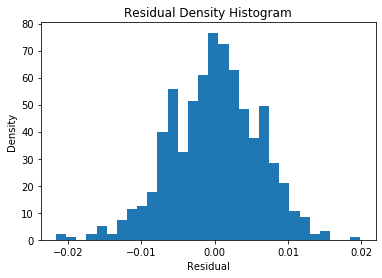

##############################

##############################
Linear model:
Predicting swap_mean_sensitivity from ['normal_additive_mean_sensitivity']


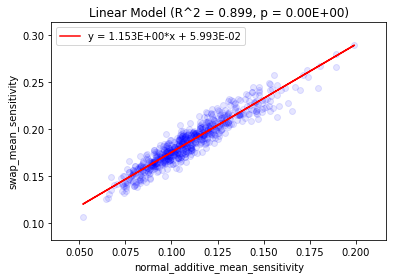

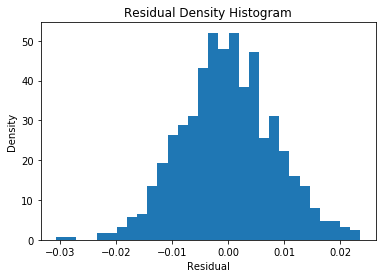

##############################

##############################
Linear model:
Predicting bootstrap_mean_sensitivity from ['normal_additive_mean_sensitivity']


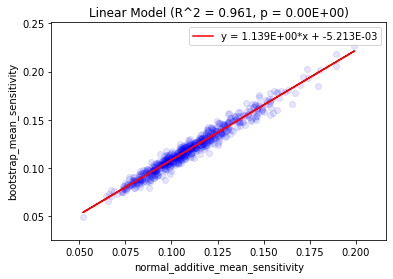

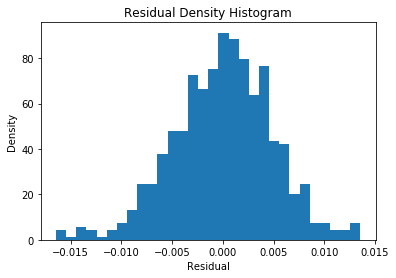

##############################



In [13]:
for s1 in range(len(grouped_sensitivities)):
    for s2 in range(s1+1, len(grouped_sensitivities)):
        run_linear_model(
            data[[grouped_sensitivities[s2]]],
            data[grouped_sensitivities[s1]],
            verbose=True)

##############################
Linear model:
Predicting overall_mean_sensitivity from ['kendall_w']


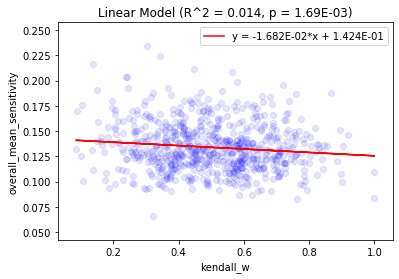

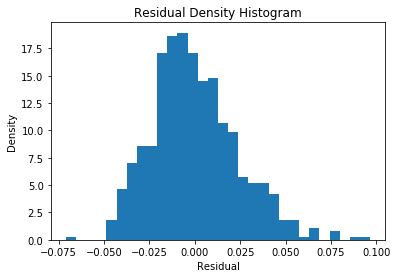

##############################

##############################
Linear model:
Predicting swap_mean_sensitivity from ['kendall_w']


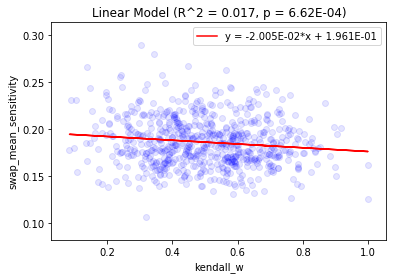

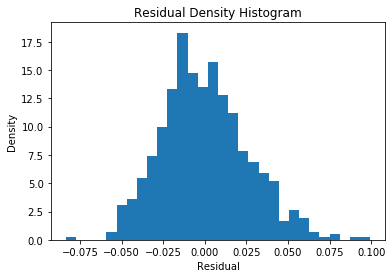

##############################

##############################
Linear model:
Predicting bootstrap_mean_sensitivity from ['kendall_w']


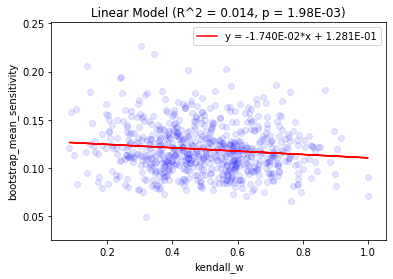

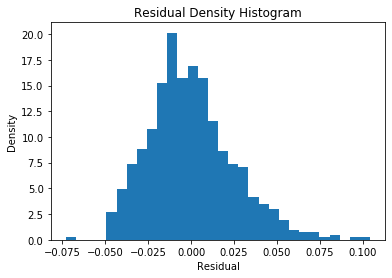

##############################

##############################
Linear model:
Predicting normal_additive_mean_sensitivity from ['kendall_w']


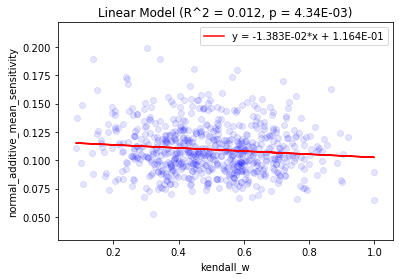

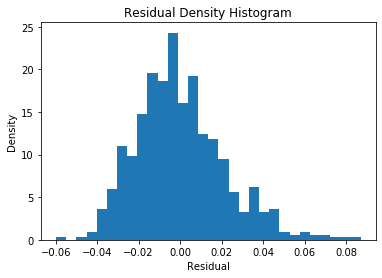

##############################

##############################
Linear model:
Predicting overall_mean_sensitivity from ['p_lowerbound']


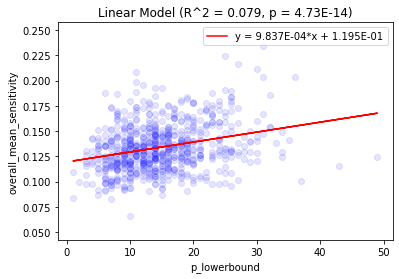

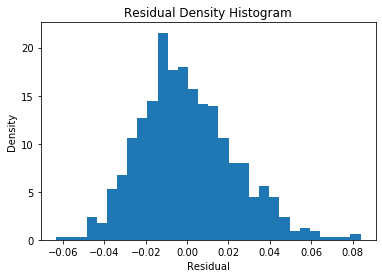

##############################

##############################
Linear model:
Predicting swap_mean_sensitivity from ['p_lowerbound']


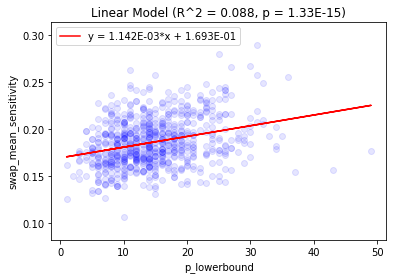

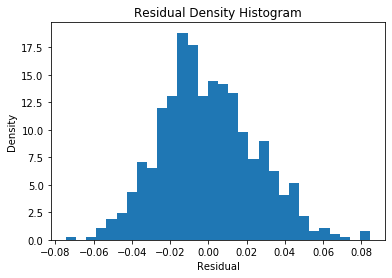

##############################

##############################
Linear model:
Predicting bootstrap_mean_sensitivity from ['p_lowerbound']


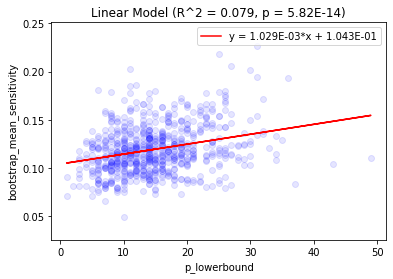

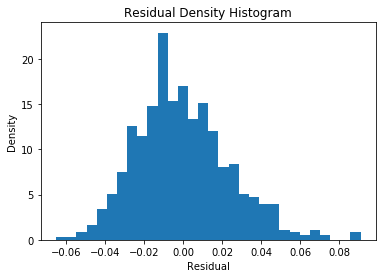

##############################

##############################
Linear model:
Predicting normal_additive_mean_sensitivity from ['p_lowerbound']


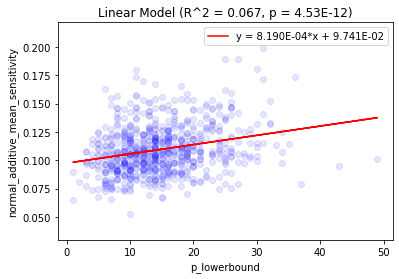

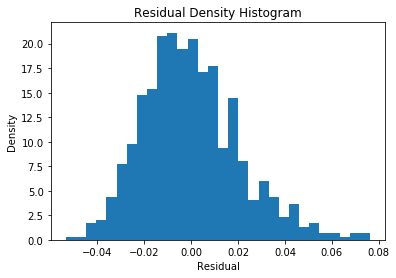

##############################

##############################
Linear model:
Predicting overall_mean_sensitivity from ['max_L2_dist']


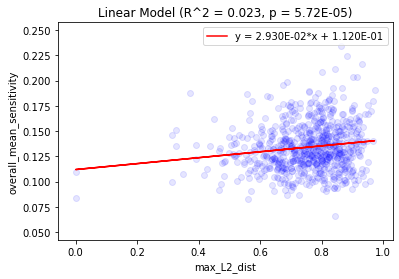

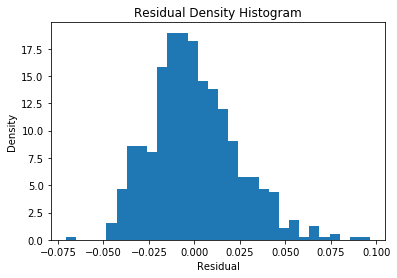

##############################

##############################
Linear model:
Predicting swap_mean_sensitivity from ['max_L2_dist']


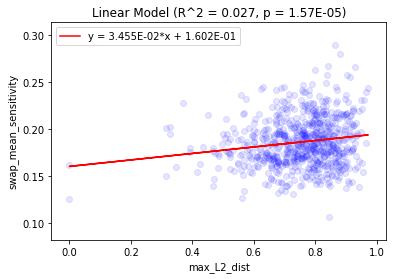

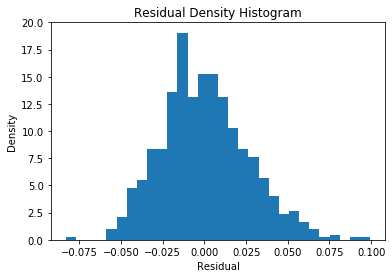

##############################

##############################
Linear model:
Predicting bootstrap_mean_sensitivity from ['max_L2_dist']


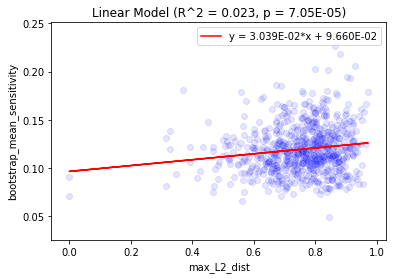

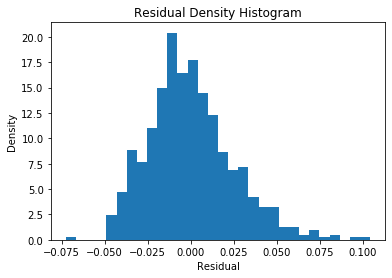

##############################

##############################
Linear model:
Predicting normal_additive_mean_sensitivity from ['max_L2_dist']


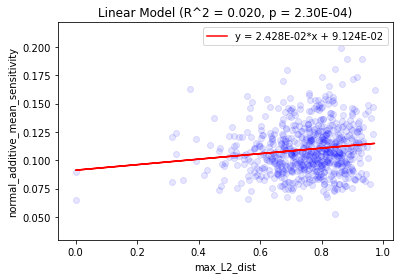

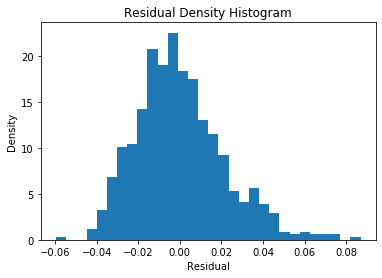

##############################

##############################
Linear model:
Predicting overall_mean_sensitivity from ['mean_L2_dist']


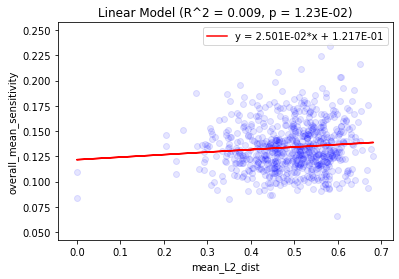

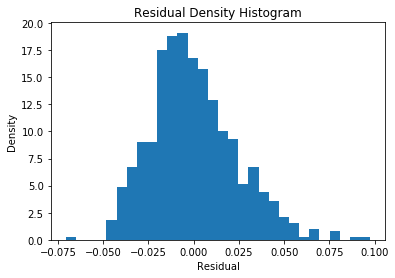

##############################

##############################
Linear model:
Predicting swap_mean_sensitivity from ['mean_L2_dist']


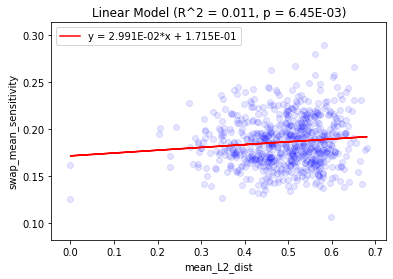

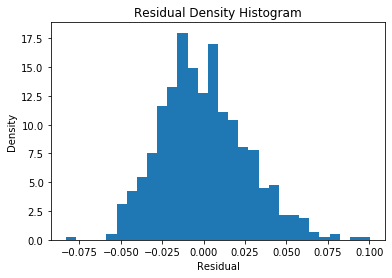

##############################

##############################
Linear model:
Predicting bootstrap_mean_sensitivity from ['mean_L2_dist']


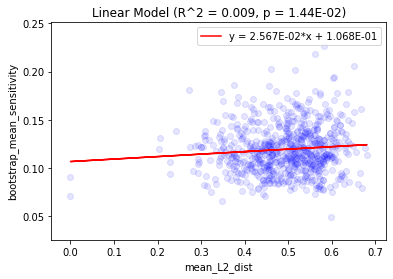

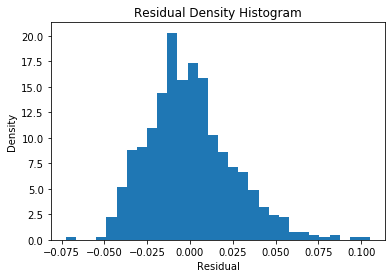

##############################

##############################
Linear model:
Predicting normal_additive_mean_sensitivity from ['mean_L2_dist']


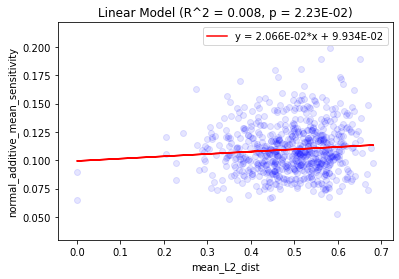

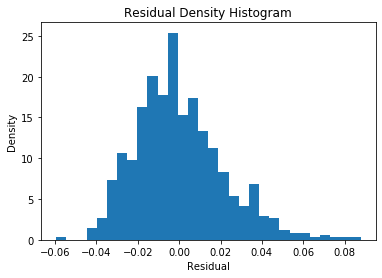

##############################

##############################
Linear model:
Predicting overall_mean_sensitivity from ['min_tau']


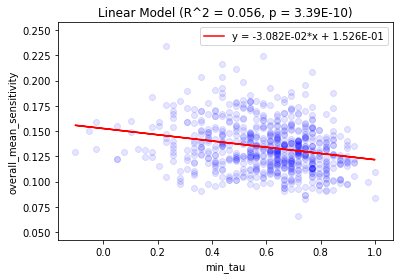

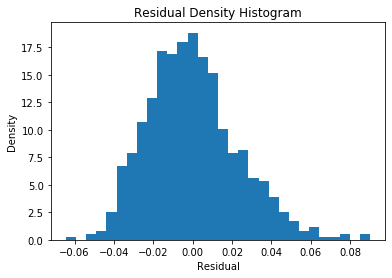

##############################

##############################
Linear model:
Predicting swap_mean_sensitivity from ['min_tau']


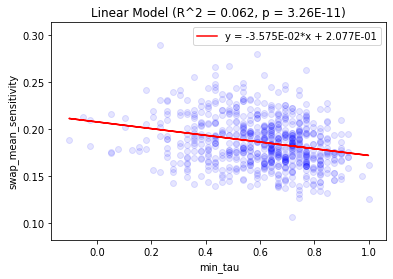

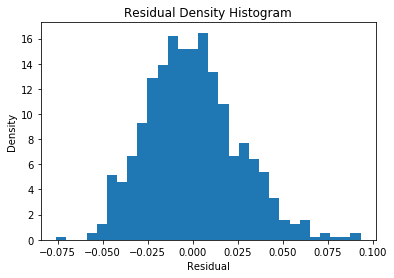

##############################

##############################
Linear model:
Predicting bootstrap_mean_sensitivity from ['min_tau']


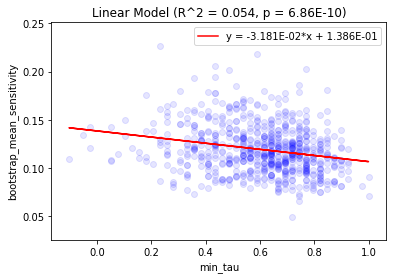

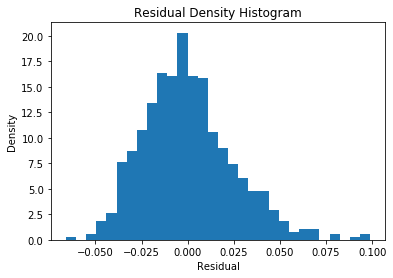

##############################

##############################
Linear model:
Predicting normal_additive_mean_sensitivity from ['min_tau']


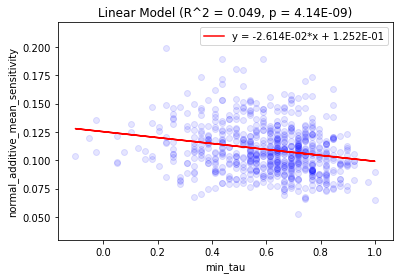

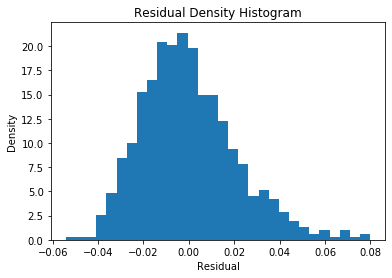

##############################

##############################
Linear model:
Predicting overall_mean_sensitivity from ['mean_tau']


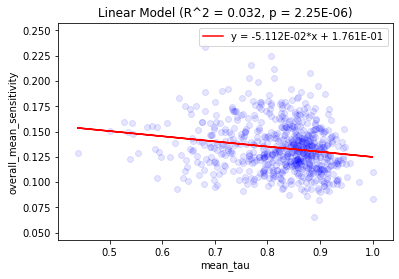

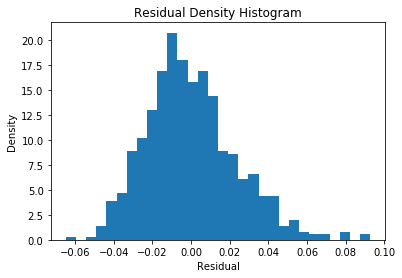

##############################

##############################
Linear model:
Predicting swap_mean_sensitivity from ['mean_tau']


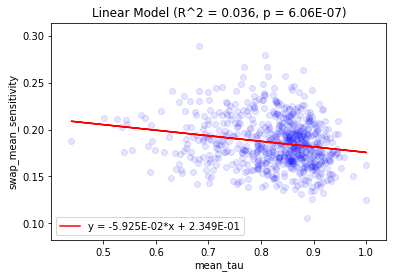

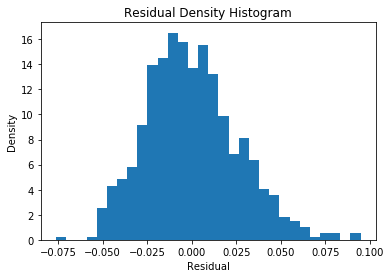

##############################

##############################
Linear model:
Predicting bootstrap_mean_sensitivity from ['mean_tau']


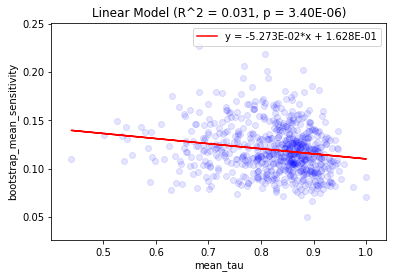

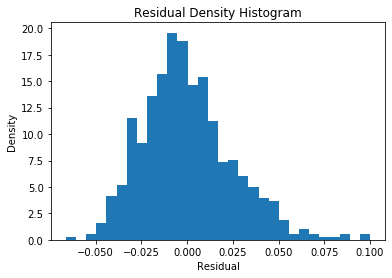

##############################

##############################
Linear model:
Predicting normal_additive_mean_sensitivity from ['mean_tau']


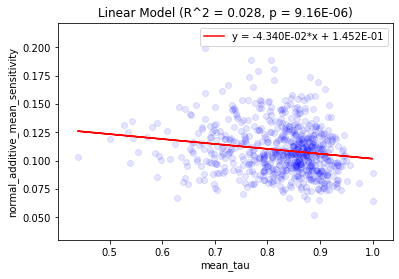

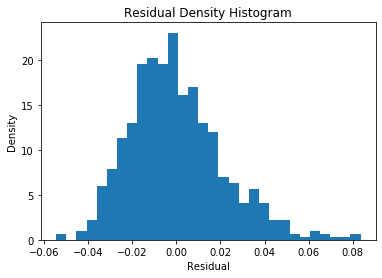

##############################

##############################
Linear model:
Predicting overall_mean_sensitivity from ['k']


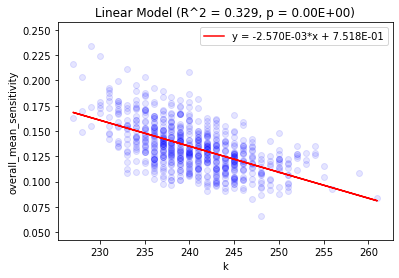

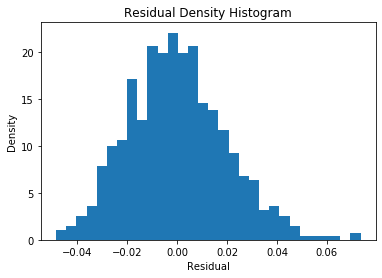

##############################

##############################
Linear model:
Predicting swap_mean_sensitivity from ['k']


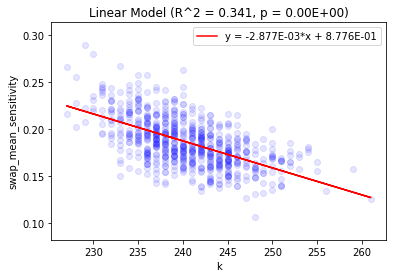

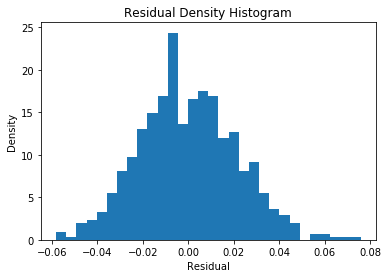

##############################

##############################
Linear model:
Predicting bootstrap_mean_sensitivity from ['k']


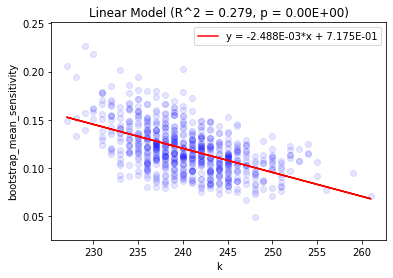

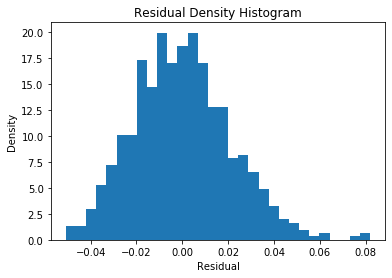

##############################

##############################
Linear model:
Predicting normal_additive_mean_sensitivity from ['k']


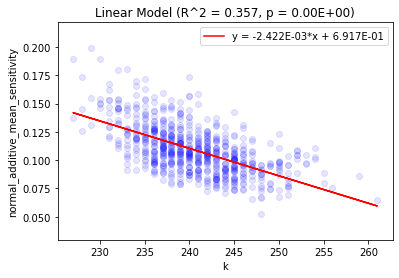

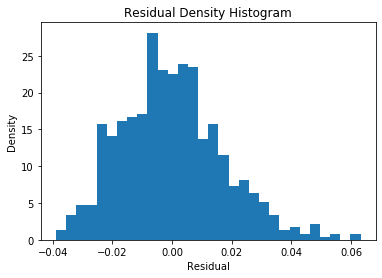

##############################

##############################
Linear model:
Predicting overall_mean_sensitivity from ['degree_of_linearity']


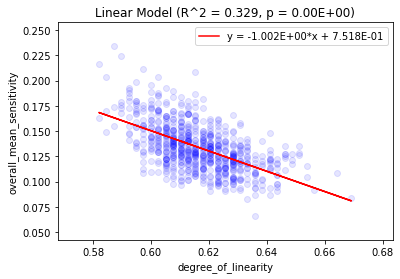

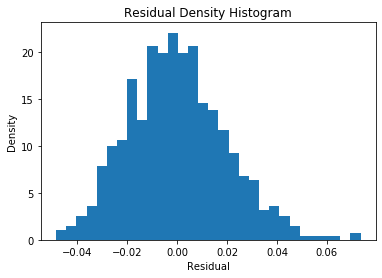

##############################

##############################
Linear model:
Predicting swap_mean_sensitivity from ['degree_of_linearity']


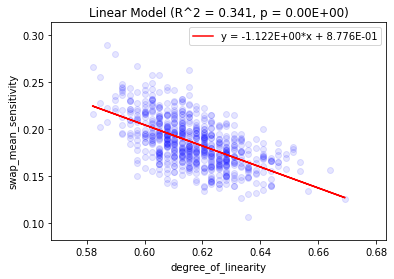

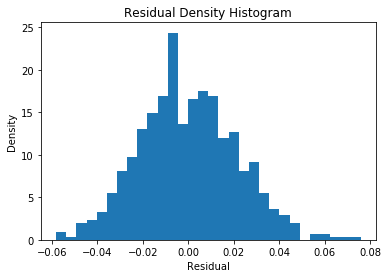

##############################

##############################
Linear model:
Predicting bootstrap_mean_sensitivity from ['degree_of_linearity']


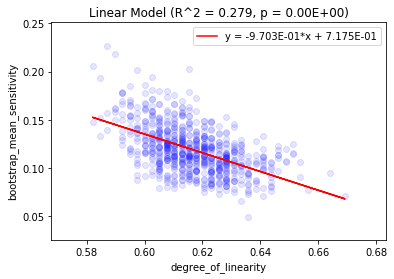

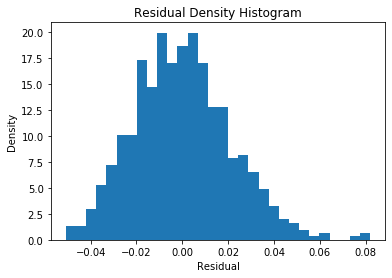

##############################

##############################
Linear model:
Predicting normal_additive_mean_sensitivity from ['degree_of_linearity']


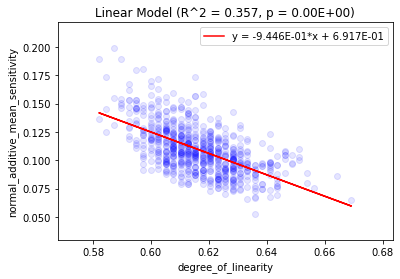

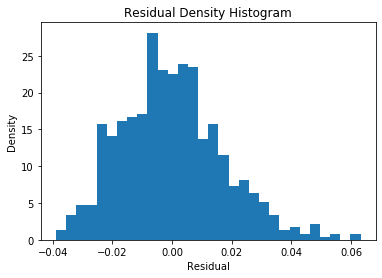

##############################

##############################
Linear model:
Predicting overall_mean_sensitivity from ['kendall_w', 'p_lowerbound', 'max_L2_dist', 'mean_L2_dist', 'min_tau', 'mean_tau', 'k', 'degree_of_linearity']

R^2 = 0.349

Predictor        Coeff    (p-value)
---------------------------------------
Intercept      :   0.6674 (p = 0.00E+00)
kendall_w      :   0.0081 (p = 7.08E-01)
p_lowerbound   :   0.0004 (p = 1.37E-02)
max_L2_dist    :   0.0001 (p = 9.95E-01)
mean_L2_dist   :  -0.0069 (p = 8.59E-01)
min_tau        :  -0.0340 (p = 3.07E-02)
mean_tau       :   0.0817 (p = 1.07E-02)
k              :  -0.0024 (p = NAN)
degree_of_linearity:  -0.0000 (p = NAN)


/data/env/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


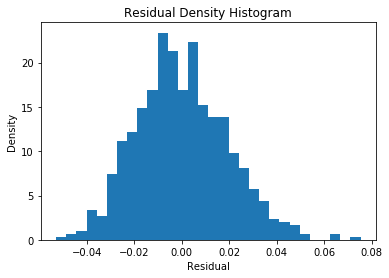

##############################



In [14]:
for measure in rankability_measures:
    X = data[[measure]]
    for sensitivity in grouped_sensitivities:
        y = data[sensitivity]
        run_linear_model(X, y, verbose=True, skip_insignificant=True, alpha=0.05)

run_linear_model(data[rankability_measures],
                 data["overall_mean_sensitivity"],
                 verbose=True,
                 skip_insignificant=True,
                 alpha=0.05)

0       12.50
1       40.50
2      110.25
3        1.00
4       20.25
        ...  
685    112.50
686     50.00
687     98.00
688     16.00
689     72.00
Length: 690, dtype: float64
##############################
Linear model:
Predicting overall_mean_sensitivity from ['predicted_p']


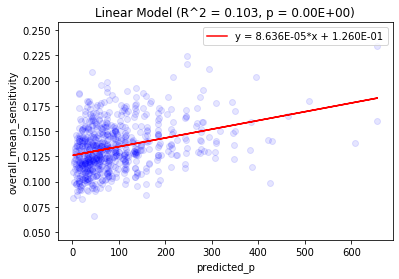

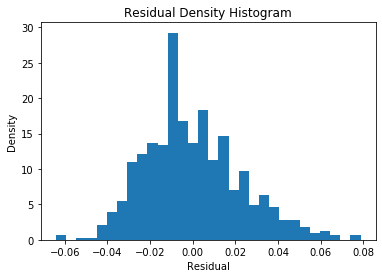

##############################



In [15]:
def read_P(string):
    return json.loads(string.replace("(", "[").replace(")", "]"))

predicted_ps = []
for P_str in data["P_repeats"]:
    P_repeats = read_P(P_str)
    P_repeats = [str(r) for r in P_repeats]
    repeats = pd.Series(P_repeats).value_counts().value_counts()
    f1 = repeats.loc[1] if 1 in repeats.index else 0
    f2 = repeats.loc[2] if 2 in repeats.index else 0.5
    predicted_ps.append(repeats.sum() + f1**2/(2*f2))
predicted_ps = pd.Series(predicted_ps, name="predicted_p")
print(predicted_ps - data["p_lowerbound"])
run_linear_model(pd.DataFrame(predicted_ps), data["overall_mean_sensitivity"], verbose=True)

##############################
Linear model:
Predicting overall_mean_sensitivity from ['predicted_p', 'degree_of_linearity']

R^2 = 0.357

Predictor        Coeff    (p-value)
---------------------------------------
Intercept      :   0.6947 (p = 0.00E+00)
predicted_p    :   0.0000 (p = 6.39E-08)
degree_of_linearity:  -0.9168 (p = 0.00E+00)


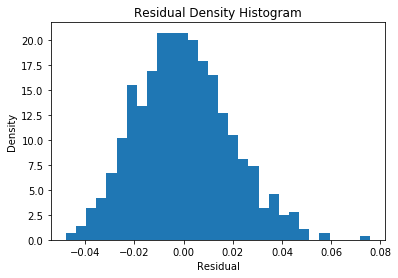

##############################



In [16]:
run_linear_model(pd.DataFrame({"predicted_p":predicted_ps, "degree_of_linearity":data["degree_of_linearity"]}), data["overall_mean_sensitivity"], verbose=True)